# **임대주택 단지 내 적정 주차수요 예측 대회**

핵심은 이런 것 같아요. 인위적으로 데이터를 바꾸면 바꿀수록 성능이 떨어진다.

문제는 데이터가 오류가 너무 많기 때문에 어디까지 전처리를 해야 하는 지 결정하는 게 아주 어렵습니다.

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor, LassoLarsCV

In [4]:
from pycaret.regression import *

In [5]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [6]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [7]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [8]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [9]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [10]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [11]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 동일 단지인 C2431에서 2로 되어 있음.

train.loc[train['버스'].isnull(), '버스'] = 2

### Rent

In [12]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [13]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [14]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## REPLACING

https://www.dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

### ※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 
 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [15]:
# ['C2085', 'C1397'] 을 C1397로 합병
train.loc[train['단지코드'] == 'C2085', '단지코드'] = 'C1397'
train.loc[train['단지코드'] == 'C1397', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1397'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1397', '공가수'] = 9

In [16]:
# ['C2431', 'C1649'] 을 C1649로 합병
train.loc[train['단지코드'] == 'C2431', '단지코드'] = 'C1649'
train.loc[train['단지코드'] == 'C1649', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1649'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1649', '공가수'] = 31
train.loc[train['단지코드'] == 'C1649', '등록차량수'] = 1214

In [17]:
# ['C1036', 'C2675'] 은 train과 test로 나누어져 있으니 drop
train.drop(train.loc[train['단지코드'] == 'C1036'].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'] == 'C2675'].index, axis=0, inplace=True)

### ※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

In [18]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]

# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]

In [19]:
# 남양주별내A1-3블록
train = train.append({'단지코드': 'C1804',
                      '총세대수': 478,
                      '임대건물구분': '아파트',
                      '지역': '경기도',
                      '공급유형': '공공임대(10년)',
                      '전용면적': 75.78,
                      '전용면적별세대수': 13,
                      '공가수': 3.0,
                      '자격유형': 'A',
                      '임대보증금': 78957000,
                      '임대료': 530130,
                      '지하철': 0.0,
                      '버스': 3.0,
                      '단지내주차면수': 629.0,
                      '등록차량수': 951.0}, ignore_index=True)
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 72,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 225013300,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.95,
                      '전용면적별세대수': 66,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 226278000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 92,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 230417000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
# 속초청초아파트
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 41.85,
                      '전용면적별세대수': 177,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 51.66,
                      '전용면적별세대수': 90,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)

In [20]:
# train의 C1024는 다른 단지와 다르게 총세대수보다 전용면적별세대수합이 더 큽니다.
train.loc[train['단지코드'] == 'C1024', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1024'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)

### ※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [21]:
# train.loc[(train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']))
#          & (train['임대건물구분'] == '아파트')]

In [22]:
# # 노이즈로 판결났으므로 부득이하게 레코드 드랍
#train.drop(train.loc[train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'].isin(['C2335', 'C1327'])].index, axis=0, inplace=True)

### UnitCount

In [23]:
train = pd.merge(train.loc[:, ~train.columns.isin(['총세대수'])],
                 train.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                 how='left', on='단지코드')

In [24]:
test = pd.merge(test.loc[:, ~test.columns.isin(['총세대수'])],
                test.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                how='left', on='단지코드')

### Qualification

'D' 는 상가에서 보여지는 자격유형입니다. 그러나 train, test 셋에 각각 존재합니다.

In [25]:
# train의 C1350의 D는 최빈값 A로 넣겠습니다.
train.loc[(train['자격유형'] == 'D') & (train['임대건물구분'] == '아파트'), '자격유형'] = (
    train.loc[(train['단지코드'] == 'C1350') & (~train['임대료'].isnull()), '자격유형'].mode()[0]
)

In [26]:
# test의 C1006의 D값은 최빈값인 C로 대체하겠습니다.
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'] = (
    test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'].mode()[0]
)

### Shops

용이한 전처리를 위해 상가는 따로 뗴어두고 나중에 합칩니다.

In [27]:
train_shops = train.loc[train['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]
test_shops = test.loc[test['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]

In [28]:
train = train.loc[train['임대건물구분'] == '아파트']
test = test.loc[test['임대건물구분'] == '아파트']

### Deposit / Rent Preprocessing

임대료가 없는 단지를 비교하기 위해서 임대료를 만들어주겠습니다.

In [29]:
# '-' 값을 0으로 만들어줍니다.
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [30]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [31]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

In [32]:
# 면적당으로 보증금과 임대료를 산출해서 역으로 채워넣겠습니다.
train['면적당보증금'] = train['임대보증금'] / train['전용면적']
train['면적당임대료'] = train['임대료'] / train['전용면적']

test['면적당보증금'] = test['임대보증금'] / test['전용면적']
test['면적당임대료'] = test['임대료'] / test['전용면적']

In [33]:
# 0 값을 다시 NULL 값으로 바꿉니다.
train.loc[(train['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
train.loc[(train['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

test.loc[(test['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
test.loc[(test['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

train에서 공공분양, 장기전세가 아니면서 보증금과 임대료가 비어있는 곳은 C1350, C1786, C2186, C1326, C1206 입니다.

In [34]:
# C1350은 공공분양이기 때문에 임대료가 없고 보증금이 매우 큽니다.
# 이 경우는 비슷한 공급유형의 면적당보증금을 가져오겠습니다.
# 임대료는 추후 작업하겠습니다.

# 같은 유형의 공공분양 단지의 면적당 보증금의 평균으로 채워줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '공공분양') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [35]:
# C1786 은 행복주택, K 유형의 아파트입니다.
# 동일한 공급유형, 자격유형의 값을 가져오겠습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료']
)

In [36]:
# C2186 단지는 같은 단지에 동일한 공급유형, 동일한 자격유형의 값이 있습니다.
# 해당 값으로 넣어주겠습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료']
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [37]:
# C1326 단지는 동일 지역에 H국민임대 단지가 없습니다. 전국적으로 4000~6500원 선이니 평균으로 넣어주겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당보증금'].mean()
)
train.loc[train['단지코드'] == 'C1326', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[train['단지코드'] == 'C1326', '임대보증금'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당보증금']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)
train.loc[train['단지코드'] == 'C1326', '임대료'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당임대료']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)

In [38]:
# C1206 단지는 동일 단지로 채워줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료']
)

test의 보증금과 임대료가 비어 있는 곳은 C1267, C2152 입니다.

In [39]:
# C1267 단지는 train의 동일공급유형, 동일자격유형, 거기에 경기도를 뺀 지역의 평균을 넣겠습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당보증금'].mean()
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '임대보증금'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금']
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '임대료'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료']
)

In [40]:
# C2152 단지는 train의 동일 공급유형, 자격유형의 전국 평균 값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당보증금'].mean()
)
test.loc[test['단지코드'] == 'C2152', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[test['단지코드'] == 'C2152', '임대보증금'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당보증금']
)
test.loc[test['단지코드'] == 'C2152', '임대료'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당임대료']
)

장기전세와 공공분양 ['C1397', 'C1039', 'C1350', 'C2470', 'C1206']

In [41]:
train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [42]:
train['면적당임대료'] = train['면적당임대료'].fillna(0)
test['면적당임대료'] = test['면적당임대료'].fillna(0)

In [43]:
train['환산보증금'] = train['임대료'] * 354 + train['임대보증금']
test['환산보증금'] = test['임대료'] * 354 + test['임대보증금']

In [44]:
train['면적당환산보증금'] = train['환산보증금'] / train['전용면적']
test['면적당환산보증금'] = test['환산보증금'] / test['전용면적']

In [45]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [46]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [47]:
train.loc[train['전용면적'] < 35, '방개수'] = '1룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '2룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '3룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '4룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '5룸'

In [48]:
test.loc[test['전용면적'] < 35, '방개수'] = '1룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '2룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '3룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '4룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '5룸'

In [752]:
rooms_cols = ['1룸비율', '2룸비율', '3룸비율', '4룸비율', '5룸비율']

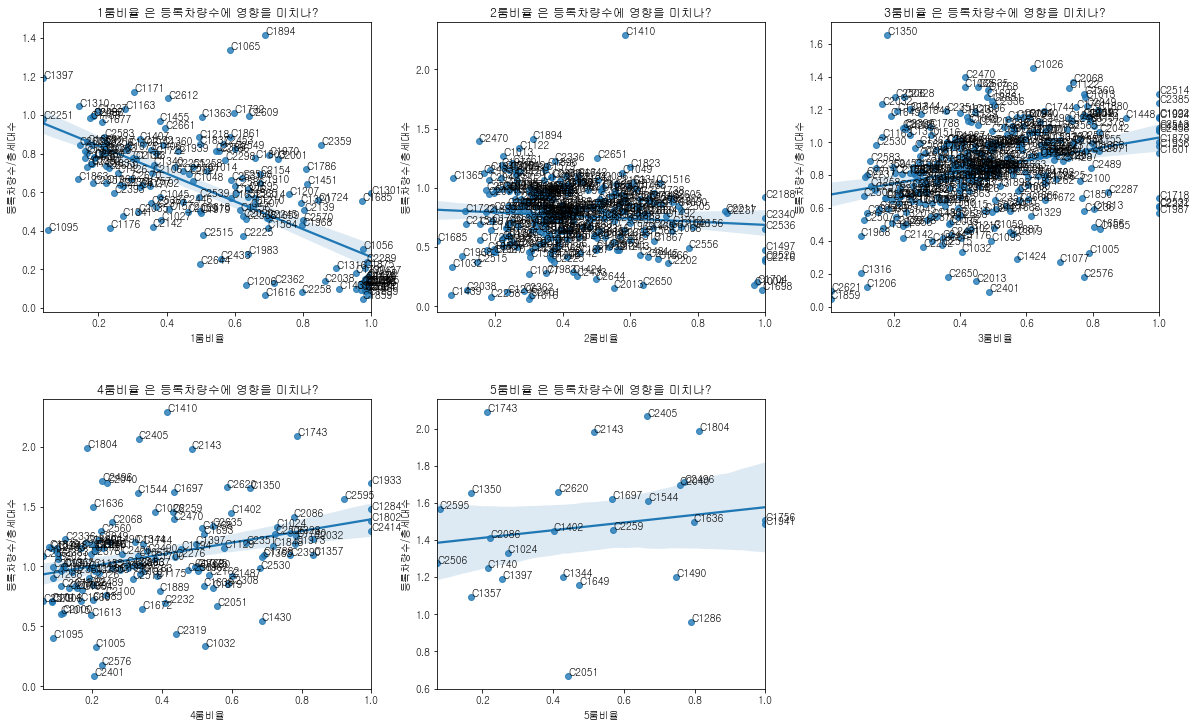

In [753]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

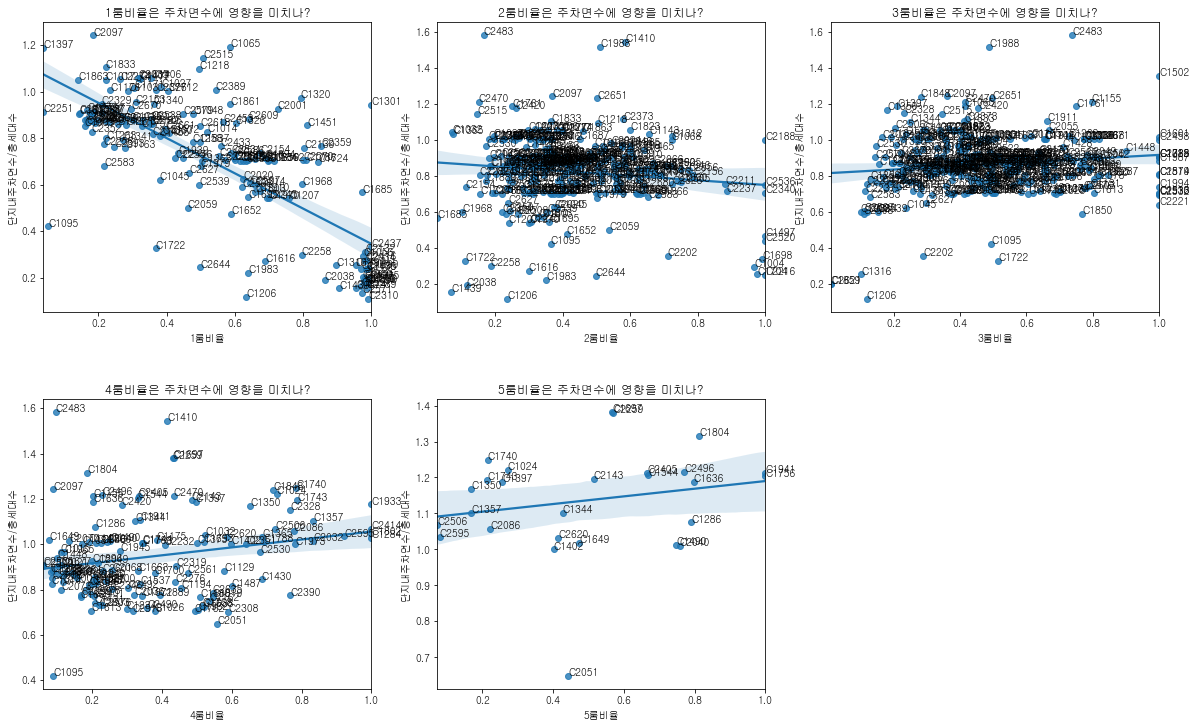

In [754]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 2. 크기 분류가 차량 보유에 영향을 미치는가?

In [679]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

In [1164]:
size = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='전용면적구분', values='전용면적별세대수',
                       aggfunc='sum')

In [757]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [758]:
size_danji = pd.concat([size, temp], axis=1)

In [759]:
size_danji['소형비율'] = size_danji['소형'] / size_danji['총세대수']
size_danji['중형비율'] = size_danji['중형'] / size_danji['총세대수']
size_danji['대형비율'] = size_danji['대형'] / size_danji['총세대수']

size_danji['단지내주차면수/총세대수'] = size_danji['단지내주차면수'] / size_danji['총세대수']
size_danji['등록차량수/총세대수'] = size_danji['등록차량수'] / size_danji['총세대수']
size_danji['등록차량수/단지내주차면수'] = size_danji['등록차량수'] / size_danji['단지내주차면수']

In [760]:
size_cols = ['소형비율', '중형비율', '대형비율']

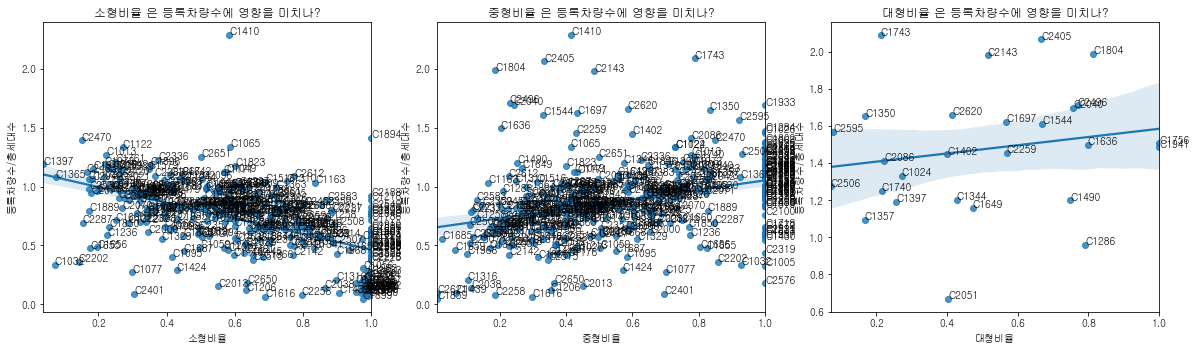

In [761]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

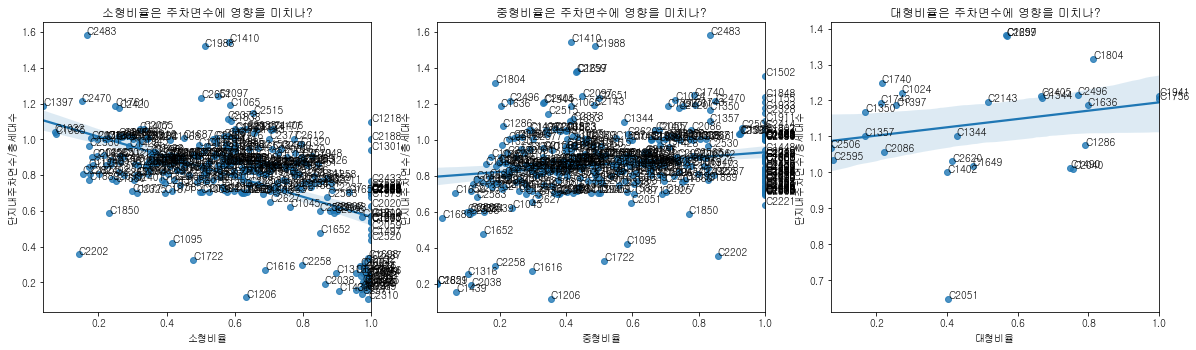

In [762]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 3. 땅값이 중요할까?

단지코드별 평균 면적당환산보증금이 그나마 지가에 가깝지 않을까 합니다

In [763]:
train_land = pd.merge(train_danji, train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index(),
                      how='inner', on='단지코드')

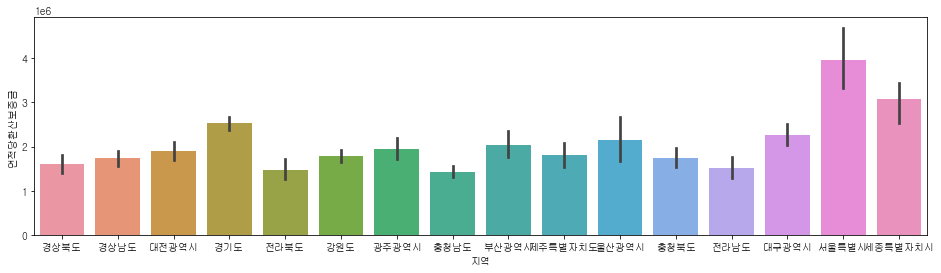

In [764]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train_land, x='지역', y='면적당환산보증금')
plt.show()

In [765]:
train_land['세대당등록차량수'] = train_land['등록차량수'] / train_land['총세대수']

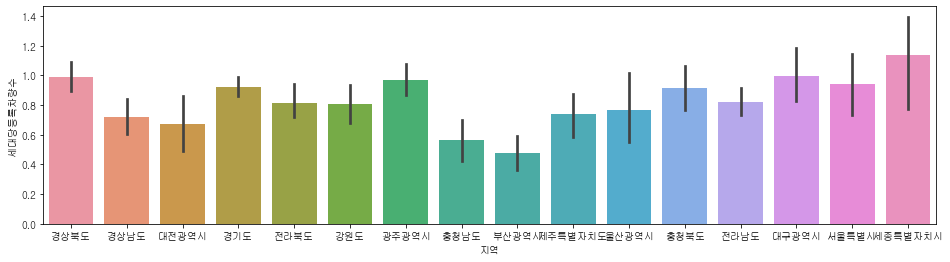

In [766]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train_land, x='지역', y='세대당등록차량수')
plt.show()

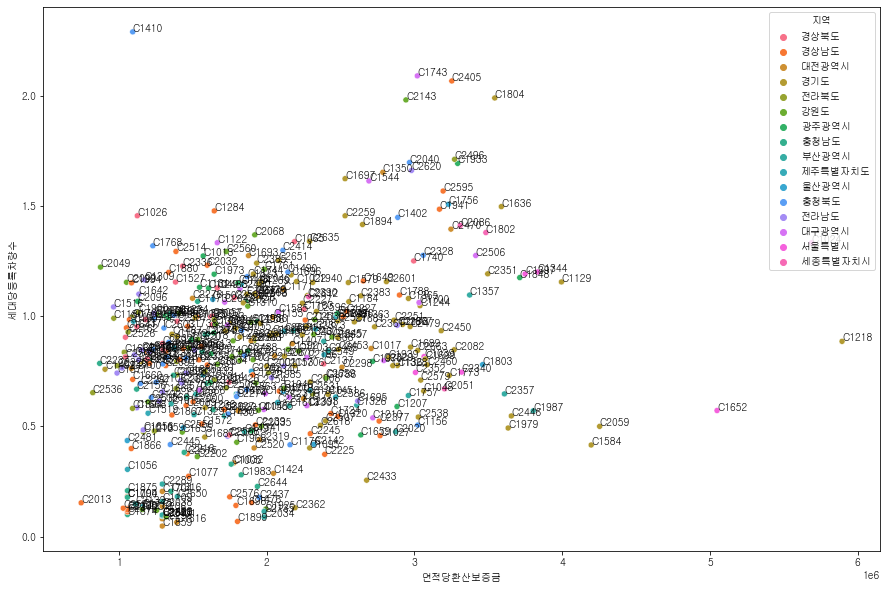

In [767]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_land, x='면적당환산보증금', y='세대당등록차량수', hue='지역')
for i, code in enumerate(train_land['단지코드']):
    plots.annotate(code, (train_land['면적당환산보증금'][i], train_land['세대당등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

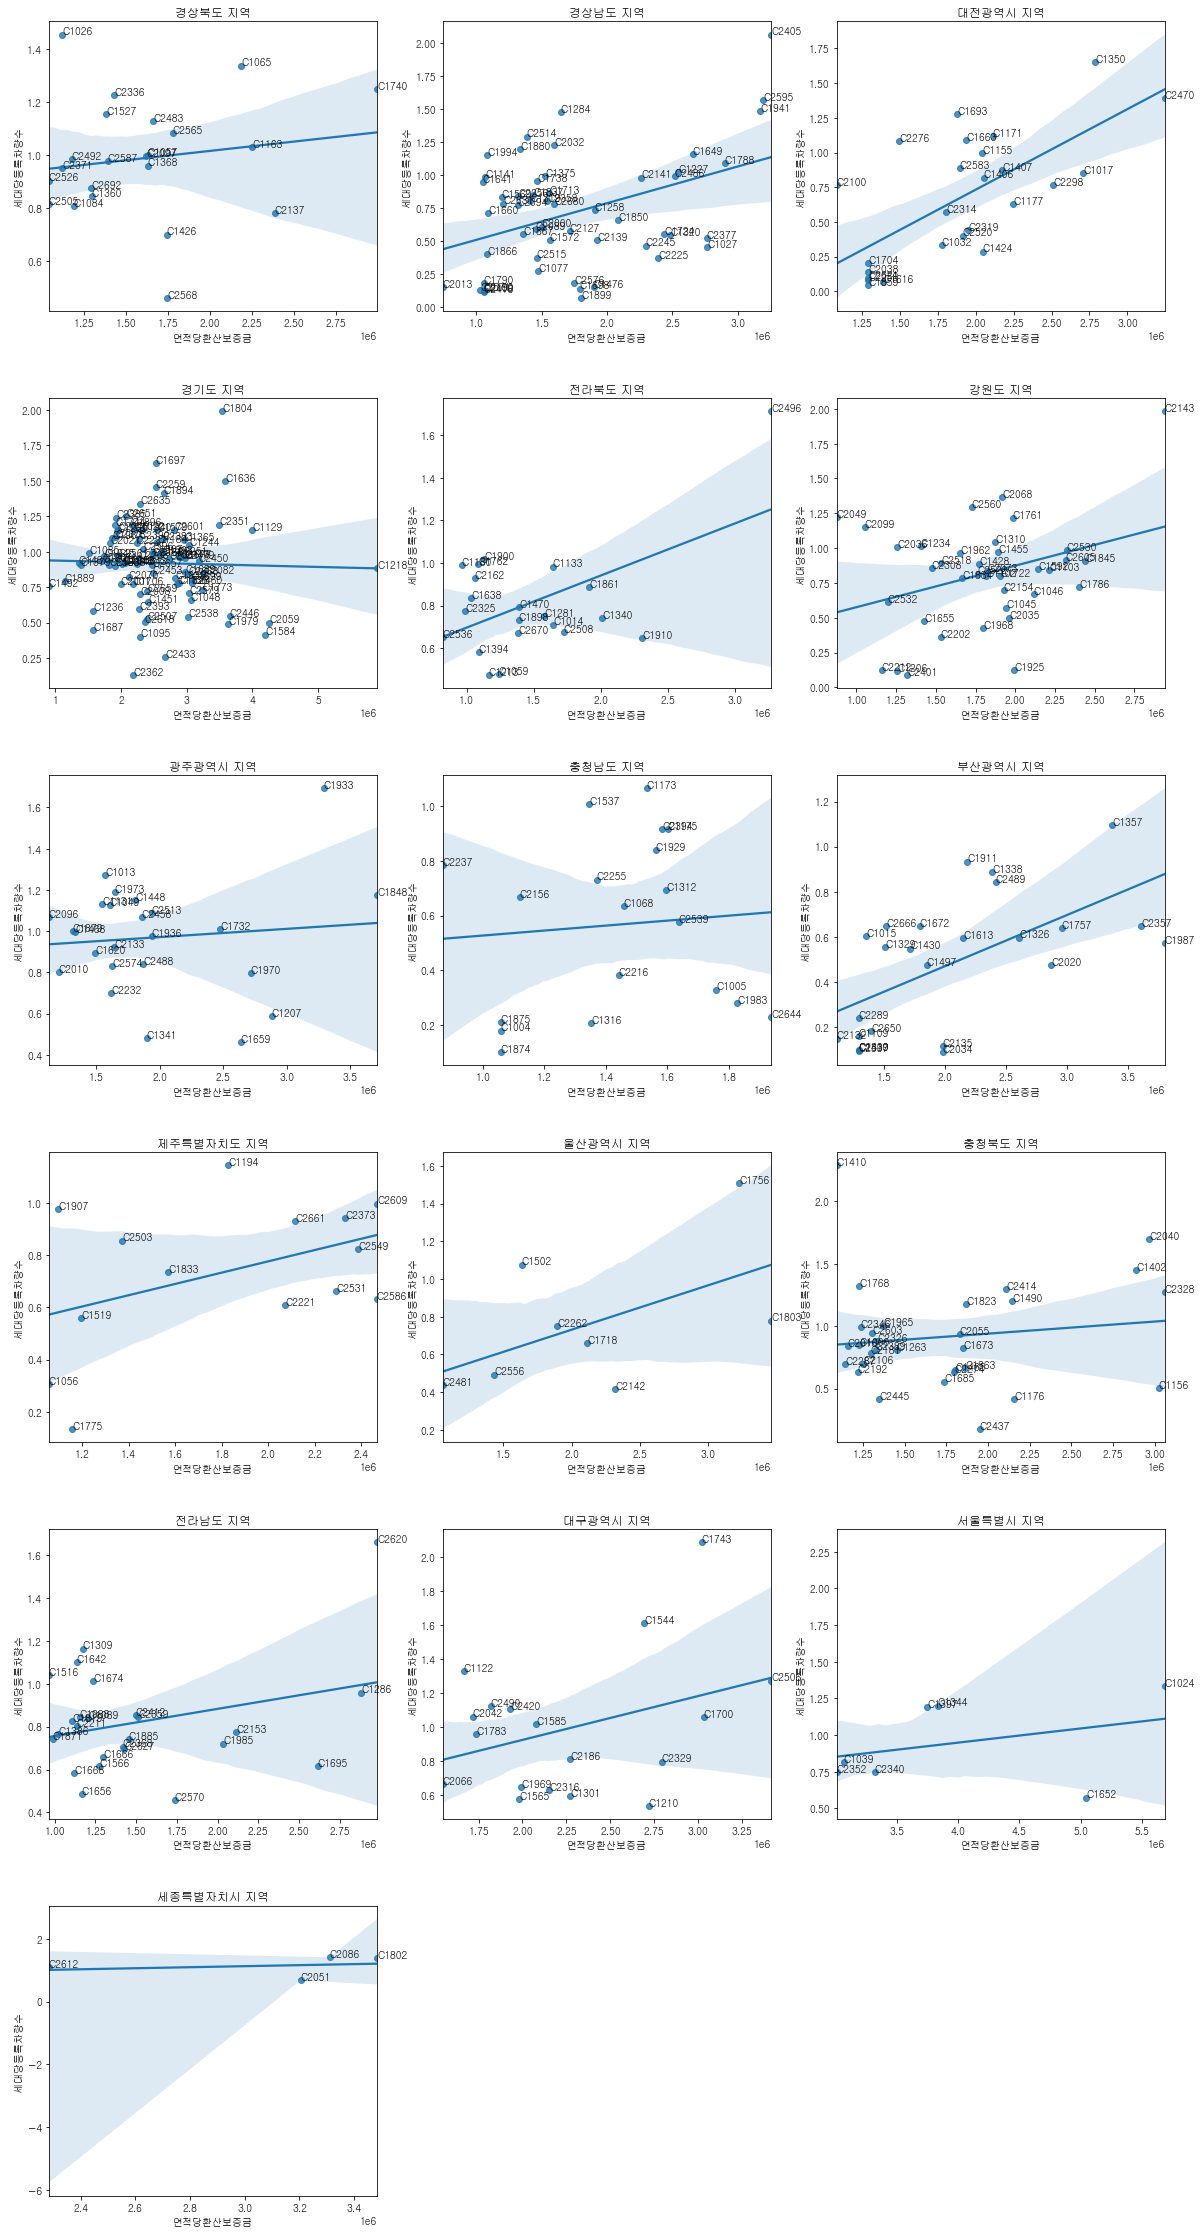

In [768]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_land['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_land.loc[train_land['지역'] == n], x='면적당환산보증금', y='세대당등록차량수')
    for i, code in enumerate(train_land.loc[train_land['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_land.loc[train_land['지역'] == n].reset_index(drop=True)['면적당환산보증금'][i],
                              train_land.loc[train_land['지역'] == n].reset_index(drop=True)['세대당등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 4. 임대기간 X 임대료

In [769]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '공공임대(10년)', '공공임대(분납)', '장기전세',
       '행복주택'], dtype=object)

- 국민임대: 최장 30년
- 공공임대: 임대 후 분양, 50년, 10년, 5년
- 공공분납: 임대 후 분양, 10년, 입주 시 보증금을 많이 내고 임대료가 낮음
- 영구임대: 국민임대의 장기 버전, 50년
- 장기전세: 전세로 장기 거주
- 행복주택: 30년, 청년은 6년


- 연도가 정해져 있지 않으면 10년으로 산정하면 얼추 맞다.

In [774]:
train.loc[~train['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    train.loc[~train['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + train.loc[~train['공급유형'].isin(['공공임대(5년)']), '임대료'] * 120
)

In [775]:
train.loc[train['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    train.loc[train['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + train.loc[train['공급유형'].isin(['공공임대(5년)']), '임대료'] * 60
)

In [780]:
test.loc[~test['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    test.loc[~test['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + test.loc[~test['공급유형'].isin(['공공임대(5년)']), '임대료'] * 120
)

In [781]:
test.loc[test['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    test.loc[test['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + test.loc[test['공급유형'].isin(['공공임대(5년)']), '임대료'] * 60
)

In [788]:
train['만기임대료X세대수'] = train['만기임대료'] * train['전용면적별세대수']
test['만기임대료X세대수'] = test['만기임대료'] * test['전용면적별세대수']

In [789]:
train_land = pd.merge(train_danji, train.groupby(['단지코드'])['만기임대료X세대수'].sum().reset_index(),
                      how='inner', on='단지코드')

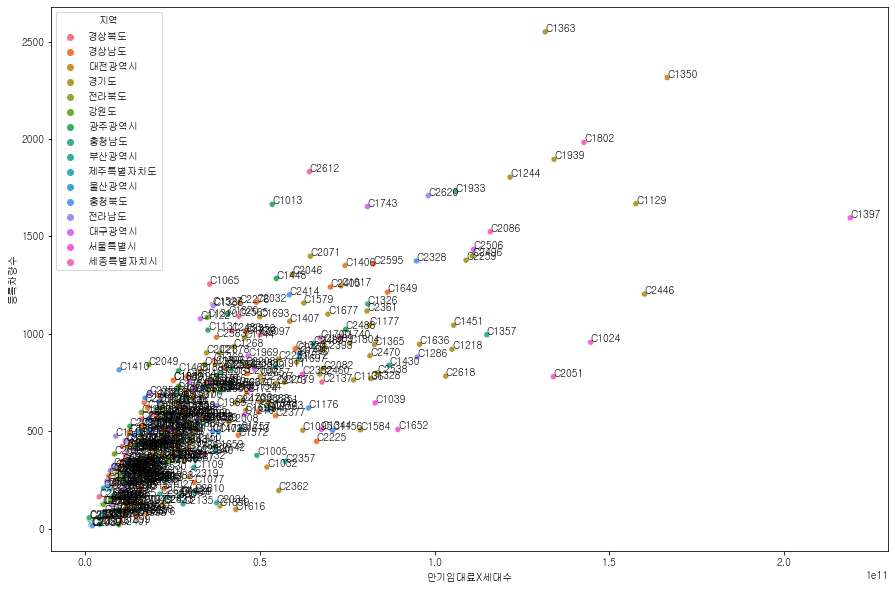

In [790]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_land, x='만기임대료X세대수', y='등록차량수', hue='지역')
for i, code in enumerate(train_land['단지코드']):
    plots.annotate(code, (train_land['만기임대료X세대수'][i], train_land['등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

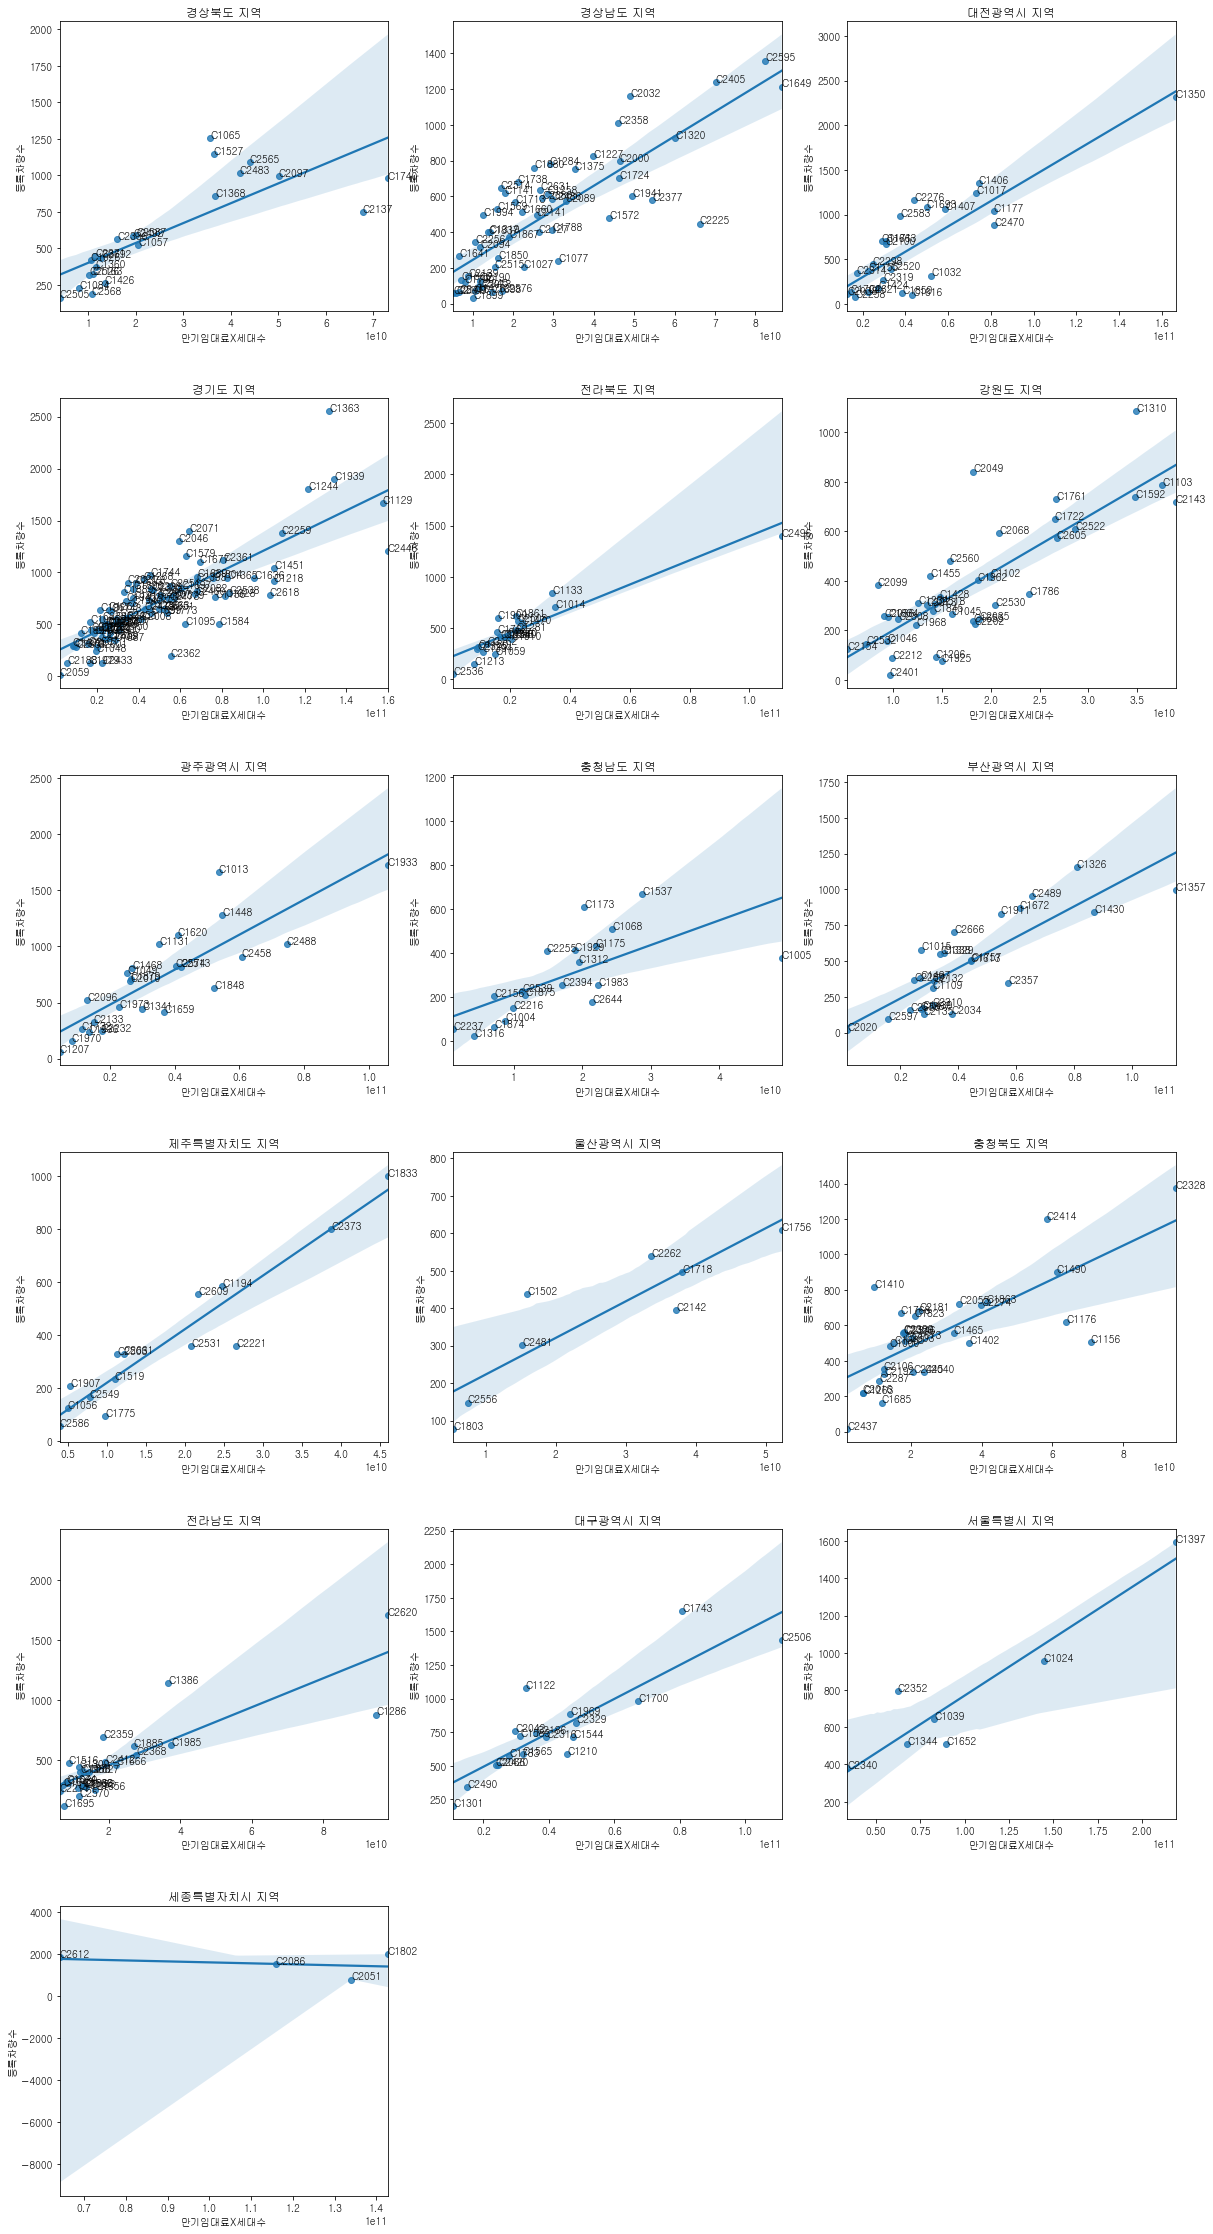

In [791]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_land['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_land.loc[train_land['지역'] == n], x='만기임대료X세대수', y='등록차량수')
    for i, code in enumerate(train_land.loc[train_land['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_land.loc[train_land['지역'] == n].reset_index(drop=True)['만기임대료X세대수'][i],
                              train_land.loc[train_land['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 5. 단지내주차면수를 총세대수로 나눈 값이면?

In [680]:
train['총세대수/주차면수'] = train['총세대수'] / train['단지내주차면수']
test['총세대수/주차면수'] = test['총세대수'] / test['단지내주차면수']

In [384]:
train_danji['총세대수/주차면수'] = train_danji['총세대수'] / train_danji['단지내주차면수']
test_danji['총세대수/주차면수'] = test_danji['총세대수'] / test_danji['단지내주차면수']

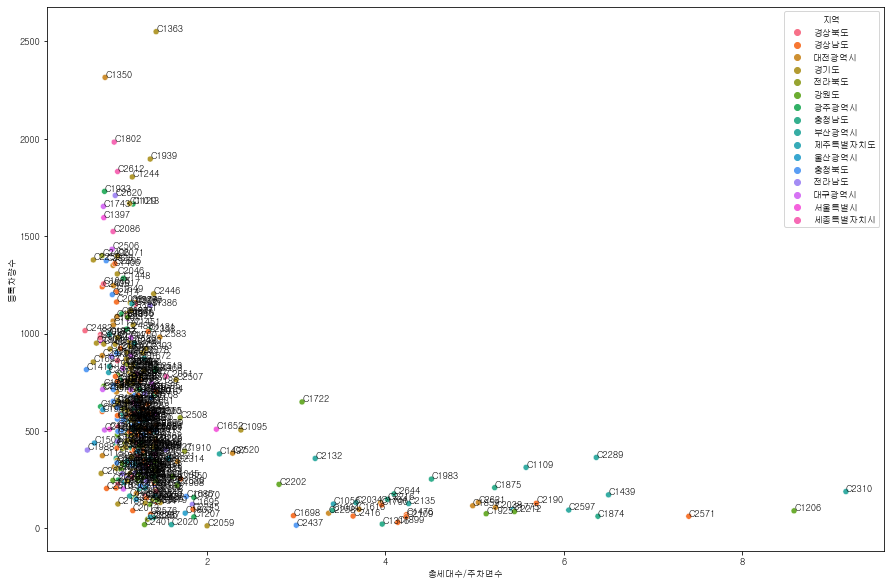

In [318]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='총세대수/주차면수', y='등록차량수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['총세대수/주차면수'][i], train_danji['등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

보통은 저 흑기둥 분포가 나와야 맞는데, 우측에 뿜어져 나오는 이상한 애들은 도대체 뭘까?

### 6. 지역, 단지 별로 총세대수를 세대수로 넣어볼까?

In [385]:
ag = age_gender.set_index('지역')

In [386]:
# 남성비
ag.loc[:, '남성비'] = ag.loc[:, (ag.columns.str.contains('여자'))].sum(axis=1)
# 여성비
ag.loc[:, '여성비'] = ag.loc[:, (ag.columns.str.contains('남자'))].sum(axis=1)
# 성인(20대~60대)비중합
ag.loc[:, '청년비중'] = ag.loc[:, (ag.columns.str.contains('20대')) | (ag.columns.str.contains('30대'))
                           | (ag.columns.str.contains('40대')) | (ag.columns.str.contains('50대'))
                           | (ag.columns.str.contains('60대'))].sum(axis=1)
# 미성년자(10대이하)비중
ag.loc[:, '미성년자비중'] = ag.loc[:, (ag.columns.str.contains('10대'))].sum(axis=1)
# 노인비중(70대~)비중합
ag.loc[:, '노년비중'] = ag.loc[:, (ag.columns.str.contains('70대')) | (ag.columns.str.contains('80대'))
                           | (ag.columns.str.contains('90대')) | (ag.columns.str.contains('100대'))].sum(axis=1)
# # 성인여성비중
# ag.loc[:, '청년여성비중'] = ag.loc[:, ['20대(여자)', '30대(여자)', '40대(여자)', '50대(여자)', '60대(여자)']].sum(axis=1)
# # 성인남성비중
# ag.loc[:, '청년남성비중'] = ag.loc[:, ['20대(남자)', '30대(남자)', '40대(남자)', '50대(남자)', '60대(남자)']].sum(axis=1)

In [392]:
ag_temp = ag.reset_index()[['지역', '남성비', '여성비', '청년비중', '미성년자비중', '노년비중']]

In [395]:
train = pd.merge(train, ag_temp, how='left', on='지역')
test = pd.merge(test, ag_temp, how='left', on='지역')

In [397]:
train['남성세대수'] = train['전용면적별세대수'] * train['남성비']
train['여성세대수'] = train['전용면적별세대수'] * train['여성비']
train['청년세대수'] = train['전용면적별세대수'] * train['청년비중']
train['미성년세대수'] = train['전용면적별세대수'] * train['미성년자비중']
train['노년세대수'] = train['전용면적별세대수'] * train['노년비중']

test['남성세대수'] = test['전용면적별세대수'] * test['남성비']
test['여성세대수'] = test['전용면적별세대수'] * test['여성비']
test['청년세대수'] = test['전용면적별세대수'] * test['청년비중']
test['미성년세대수'] = test['전용면적별세대수'] * test['미성년자비중']
test['노년세대수'] = test['전용면적별세대수'] * test['노년비중']

In [404]:
train.drop(['남성비', '여성비', '청년비중', '미성년자비중', '노년비중'], axis=1, inplace=True)
test.drop(['남성비', '여성비', '청년비중', '미성년자비중', '노년비중'], axis=1, inplace=True)

In [406]:
train_ag = pd.merge(train_danji,
         train.groupby(['단지코드'])[['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수']].sum().reset_index(),
         how='inner', on='단지코드')

In [413]:
ag_cols = ['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수']

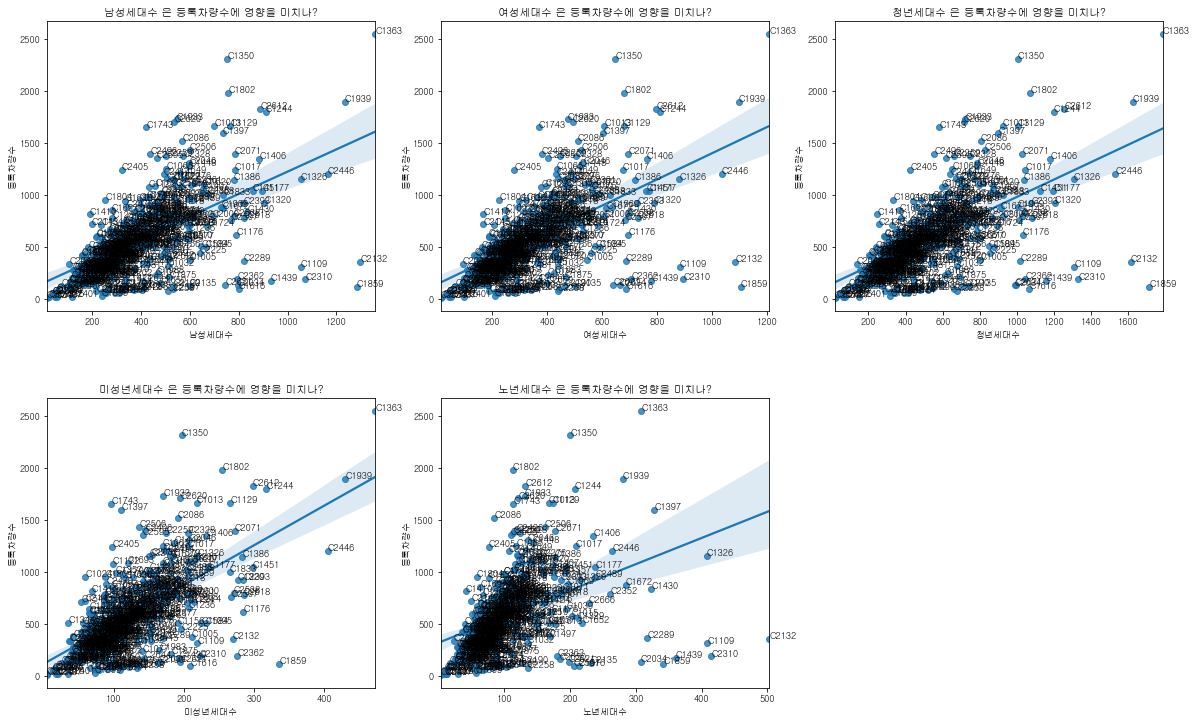

In [414]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(ag_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_ag, x=n, y='등록차량수')
    for i, code in enumerate(train_ag.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (train_ag.reset_index(drop=False)[n][i],
                              train_ag.reset_index(drop=False)['등록차량수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

### 7. 뭐가 또 있을 것 같은데

In [60]:
train

,단지코드,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,총세대수,면적당보증금,면적당임대료,환산보증금,면적당환산보증금,건축연면적,세대수X환산보증금,방개수,전용면적구분,총세대수/주차면수
0,C2483,아파트,경상북도,국민임대,39.72,134,38.0,A,1.566700e+07,103680.000000,0.0,3.0,1425.0,1015.0,900,3.944361e+05,2610.271903,5.236972e+07,1.318472e+06,5322.48,7.017542e+09,2룸,소형,0.631579
1,C2483,아파트,경상북도,국민임대,39.72,15,38.0,A,1.566700e+07,103680.000000,0.0,3.0,1425.0,1015.0,900,3.944361e+05,2610.271903,5.236972e+07,1.318472e+06,595.80,7.855458e+08,2룸,소형,0.631579
2,C2483,아파트,경상북도,국민임대,51.93,385,38.0,A,2.730400e+07,184330.000000,0.0,3.0,1425.0,1015.0,900,5.257847e+05,3549.585981,9.255682e+07,1.782338e+06,19993.05,3.563438e+10,3룸,중형,0.631579
3,C2483,아파트,경상북도,국민임대,51.93,15,38.0,A,2.730400e+07,184330.000000,0.0,3.0,1425.0,1015.0,900,5.257847e+05,3549.585981,9.255682e+07,1.782338e+06,778.95,1.388352e+09,3룸,중형,0.631579
4,C2483,아파트,경상북도,국민임대,51.93,41,38.0,A,2.730400e+07,184330.000000,0.0,3.0,1425.0,1015.0,900,5.257847e+05,3549.585981,9.255682e+07,1.782338e+06,2129.13,3.794830e+09,3룸,중형,0.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,C2470,아파트,대전광역시,공공분양,74.99,72,1.0,A,2.250133e+08,0.000000,1.0,2.0,772.0,887.0,636,3.000577e+06,0.000000,2.250133e+08,3.000577e+06,5399.28,1.620096e+10,4룸,중형,0.823834
2947,C2470,아파트,대전광역시,공공분양,74.95,66,1.0,A,2.262780e+08,0.000000,1.0,2.0,772.0,887.0,636,3.019053e+06,0.000000,2.262780e+08,3.019053e+06,4946.70,1.493435e+10,4룸,중형,0.823834
2948,C2470,아파트,대전광역시,공공분양,74.99,92,1.0,A,2.304170e+08,0.000000,1.0,2.0,772.0,887.0,636,3.072636e+06,0.000000,2.304170e+08,3.072636e+06,6899.08,2.119836e+10,4룸,중형,0.823834
2949,C1206,아파트,강원도,영구임대,41.85,177,1.0,C,1.259998e+07,136173.156474,0.0,4.0,88.0,90.0,755,3.010748e+05,3253.838864,6.080528e+07,1.452934e+06,7407.45,1.076253e+10,2룸,중형,8.579545


### 99. 지역별 세대, 성별 분포는 어떤 영향을 미칠까?

In [320]:
ag = age_gender.set_index('지역')

In [321]:
# 성인(20대~60대)비중합
ag.loc[:, '청년비중'] = ag.loc[:, (ag.columns.str.contains('20대')) | (ag.columns.str.contains('30대')) | (ag.columns.str.contains('40대')) | (ag.columns.str.contains('50대')) | (ag.columns.str.contains('60대'))].sum(axis=1)
# 미성년자(10대이하)비중
ag.loc[:, '미성년자비중'] = ag.loc[:, (ag.columns.str.contains('10대'))].sum(axis=1)
# 노인비중(70대~)비중합
ag.loc[:, '노년비중'] = ag.loc[:, (ag.columns.str.contains('70대')) | (ag.columns.str.contains('80대')) | (ag.columns.str.contains('90대')) | (ag.columns.str.contains('100대'))].sum(axis=1)
# 성인여성비중
ag.loc[:, '청년여성비중'] = ag.loc[:, ['20대(여자)', '30대(여자)', '40대(여자)', '50대(여자)', '60대(여자)']].sum(axis=1)
# 성인남성비중
ag.loc[:, '청년남성비중'] = ag.loc[:, ['20대(남자)', '30대(남자)', '40대(남자)', '50대(남자)', '60대(남자)']].sum(axis=1)

# Modeling

In [681]:
train.head()

,단지코드,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,총세대수,면적당보증금,면적당임대료,환산보증금,면적당환산보증금,건축연면적,세대수X환산보증금,방개수,전용면적구분,총세대수/주차면수
0,C2483,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,900,394436.052367,2610.271903,52369720.0,1.318472e+06,5322.48,7.017542e+09,2룸,소형,0.631579
1,C2483,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,900,394436.052367,2610.271903,52369720.0,1.318472e+06,595.80,7.855458e+08,2룸,소형,0.631579
2,C2483,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,900,525784.710187,3549.585981,92556820.0,1.782338e+06,19993.05,3.563438e+10,3룸,중형,0.631579
3,C2483,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,900,525784.710187,3549.585981,92556820.0,1.782338e+06,778.95,1.388352e+09,3룸,중형,0.631579
4,C2483,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,900,525784.710187,3549.585981,92556820.0,1.782338e+06,2129.13,3.794830e+09,3룸,중형,0.631579


In [682]:
# temp = train.groupby(['단지코드'])['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수'].sum().reset_index()
# train = pd.merge(train.loc[:, ~train.columns.isin(['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수'])],
#                  temp, on='단지코드')
# temp = test.groupby(['단지코드'])['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수'].sum().reset_index()
# test = pd.merge(test.loc[:, ~test.columns.isin(['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수'])],
#                 temp, on='단지코드')

In [683]:
# 공급유형 unstack
temp = train.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['공급유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['공급유형'])], temp, on='단지코드')

In [684]:
# 자격유형 unstack
temp = train.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['자격유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['자격유형'])], temp, on='단지코드')

In [685]:
# 면적당환산보증금세대수 합계로 산출
temp = train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')

In [686]:
# 단지평균면적당환산보증금 산출
temp = train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['면적당환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['면적당환산보증금'])], temp, on='단지코드')

In [687]:
# 방개수 unstack
temp = train.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['방개수'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['방개수'])], temp, on='단지코드')

In [688]:
# 전용면적구분 unstack
temp = train.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['전용면적구분'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['전용면적구분'])], temp, on='단지코드')

In [689]:
# 건축연면적 합계로 산출
temp = train.groupby(['단지코드'])['건축연면적'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['건축연면적'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['건축연면적'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['건축연면적'])], temp, on='단지코드')

In [690]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

In [691]:
# 전처리가 끝나서 필요없는 변수 삭제
train.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
            '임대료', '환산보증금', '면적당보증금', '면적당임대료'], axis=1, inplace=True)
test.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
           '임대료', '환산보증금', '면적당보증금', '면적당임대료'], axis=1, inplace=True)

In [692]:
# 단지고유의 레코드만 남겨줍니다.
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [693]:
train.shape, test.shape

((420, 43), (147, 36))

In [694]:
set(train.columns).difference(test.columns)

{'B', 'F', 'O', '공공분양', '공공임대(5년)', '등록차량수', '장기전세'}

In [695]:
train.drop(['B', 'F', 'O', '장기전세', '공공분양', '공공임대(5년)'], axis=1, inplace=True)

In [696]:
train.head()

,단지코드,지역,공가수,지하철,버스,단지내주차면수,등록차량수,총세대수,총세대수/주차면수,공공임대(10년),공공임대(50년),공공임대(분납),국민임대,영구임대,행복주택,A,C,E,G,H,I,J,K,L,M,N,세대수X환산보증금,면적당환산보증금,1룸,2룸,3룸,4룸,5룸,대형,소형,중형,건축연면적
0,C2483,3,38.0,0.0,3.0,1425.0,1015.0,900,0.631579,0.0,0.0,0.0,900.0,0.0,0.0,900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.848731e+10,1.665119e+06,0.0,149.0,665.0,86.0,0.0,0.0,149.0,751.0,45605.89
1,C2515,10,17.0,0.0,3.0,624.0,205.0,545,0.873397,0.0,0.0,0.0,545.0,0.0,0.0,545.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.069148e+10,1.461542e+06,276.0,80.0,189.0,0.0,0.0,0.0,356.0,189.0,21941.82
2,C1407,13,13.0,1.0,1.0,1285.0,1064.0,1216,0.946304,0.0,0.0,0.0,1216.0,0.0,0.0,1216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.072339e+11,2.173057e+06,390.0,362.0,464.0,0.0,0.0,0.0,390.0,826.0,49159.08
3,C1945,1,6.0,1.0,3.0,734.0,730.0,755,1.028610,0.0,0.0,0.0,755.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.703930e+10,1.748453e+06,0.0,240.0,303.0,212.0,0.0,0.0,240.0,515.0,37962.15
4,C1470,8,14.0,0.0,2.0,645.0,553.0,696,1.079070,0.0,0.0,0.0,696.0,0.0,0.0,696.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.440690e+10,1.390810e+06,0.0,254.0,442.0,0.0,0.0,0.0,254.0,442.0,31250.88


In [697]:
test.head()

,단지코드,지역,공가수,지하철,버스,단지내주차면수,총세대수,총세대수/주차면수,공공임대(10년),공공임대(50년),공공임대(분납),국민임대,영구임대,행복주택,A,C,E,G,H,I,J,K,L,M,N,세대수X환산보증금,면적당환산보증금,1룸,2룸,3룸,4룸,5룸,대형,소형,중형,건축연면적
0,C1072,1,14.0,0.0,2.0,683.0,754,1.103953,0.0,0.0,0.0,754.0,0.0,0.0,30.0,0.0,0.0,0.0,724.0,0.0,0.0,0.0,0.0,0.0,0.0,9.892643e+10,2.713866e+06,0.0,116.0,638.0,0.0,0.0,0.0,116.0,638.0,36394.95
1,C1128,1,9.0,0.0,3.0,1216.0,1354,1.113487,0.0,0.0,0.0,1354.0,0.0,0.0,222.0,0.0,0.0,0.0,1132.0,0.0,0.0,0.0,0.0,0.0,0.0,1.680103e+11,2.594390e+06,0.0,420.0,934.0,0.0,0.0,0.0,420.0,934.0,63429.68
2,C1456,15,18.0,0.0,16.0,547.0,619,1.131627,0.0,0.0,0.0,619.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.042407e+10,2.488889e+06,82.0,165.0,328.0,44.0,0.0,0.0,247.0,372.0,27958.80
3,C1840,8,7.0,0.0,3.0,543.0,593,1.092081,0.0,0.0,0.0,593.0,0.0,0.0,593.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.596387e+10,1.397721e+06,0.0,335.0,258.0,0.0,0.0,0.0,335.0,258.0,25778.67
4,C1332,1,11.0,0.0,2.0,1112.0,1297,1.166367,0.0,0.0,0.0,1297.0,0.0,0.0,0.0,0.0,0.0,0.0,1297.0,0.0,0.0,0.0,0.0,0.0,0.0,1.824962e+11,3.090162e+06,0.0,425.0,872.0,0.0,0.0,0.0,425.0,872.0,59456.73


In [698]:
train.shape, test.shape

((420, 37), (147, 36))

In [699]:
# ag = ag.reset_index()
# ag['지역'] = ag['지역'].map(region_dict)

In [700]:
train = pd.merge(train, train_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index(),
                 how='left', on='단지코드')
test = pd.merge(test, test_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index(),
                how='left', on='단지코드')

In [701]:
train = train.fillna(0)
test = test.fillna(0)

In [702]:
train.shape, test.shape

((420, 39), (147, 38))

In [703]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]
x_code = test['단지코드']

In [704]:
x_train.shape, y_train.shape, x_test.shape, x_code.shape

((420, 37), (420,), (147, 37), (147,))

In [705]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [706]:
rf.oob_score_

0.7785322333466153

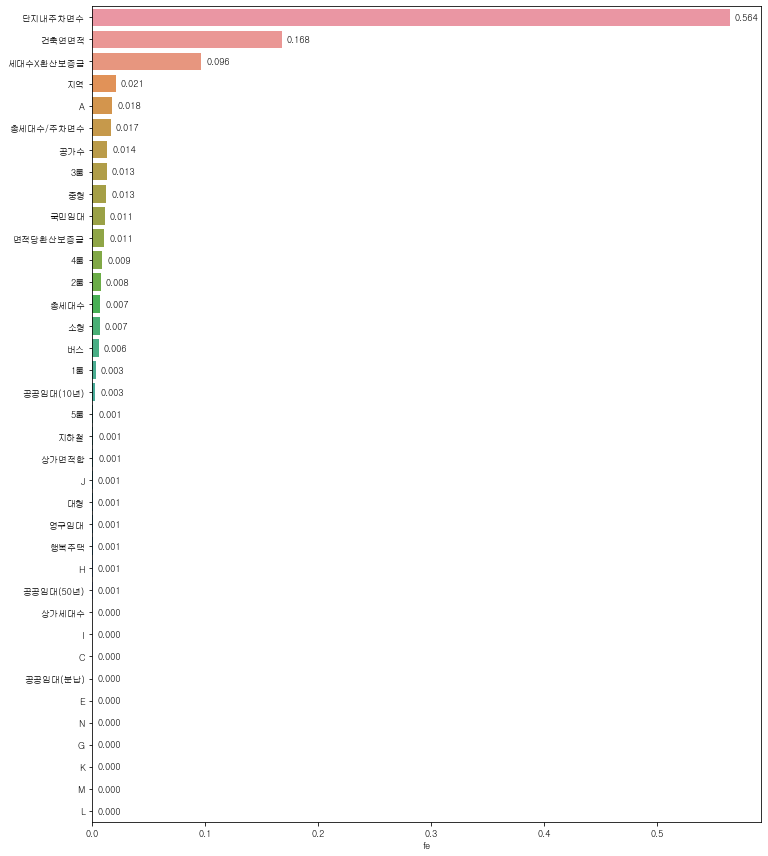

In [707]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [714]:
pred = pred.round()

In [715]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [716]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [717]:
sub

,code,num
0,C1072,801.0
1,C1128,1172.0
2,C1456,530.0
3,C1840,533.0
4,C1332,1265.0
...,...,...
145,C2456,216.0
146,C1266,477.0
147,C2152,53.0
148,C1267,393.0


In [718]:
sub.to_csv('submission/parking_210719_reset.csv', index=False)

In [179]:
sub

,code,num
0,C1072,802.695
1,C1128,1179.145
2,C1456,528.420
3,C1840,535.135
4,C1332,1264.860
5,C1563,2025.620
6,C1794,933.615
7,C1640,542.155
8,C1377,374.650
9,C2072,276.795


In [180]:
sub_best = pd.read_csv('submission/parking_210718_총세대수주차면수비.csv')

In [711]:
sub_best

,code,num
0,C1072,795.190
1,C1128,1175.865
2,C1456,514.790
3,C1840,529.990
4,C1332,1263.795
...,...,...
145,C2456,215.785
146,C1266,482.460
147,C2152,53.725
148,C1267,385.675


## FEATURE SELECTION

In [269]:
# RFE는 Recursive Feature Elimination이라고 하여, 반복하여 변수를 제거해나가는 방식입니다.
from sklearn.feature_selection import RFE

In [449]:
model = RandomForestRegressor(random_state=42)
rfe = RFE(model,
          5) # feature의 개수를 지정할 수 있습니다. 3개로 해봅니다.
rfe_fit = rfe.fit(x_train, y_train)

In [450]:
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 5
Selected Features: [False False False False  True False  True False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False  True  True False False]
Feature Ranking: [ 2  5 20 14  1 19  1 18 12 15  4 13 17 26 33 10 25 24  3 31 32 36 22 29
 28 34 38 37 35  1  7 16 11  6  9 21 27  8  1  1 30 23]


In [451]:
# rank를 확인할 수도 있습니다.
rfe_select = pd.DataFrame(rfe_fit.support_.tolist(), index=x_train.columns, columns=['true'])
rfe_select['rank'] = rfe_fit.ranking_.tolist()
rfe_select.sort_values('rank')

,true,rank
세대수X환산보증금,True,1
중형,True,1
건축연면적,True,1
총세대수/주차면수,True,1
단지내주차면수,True,1
지역,False,2
A,False,3
미성년세대수,False,4
공가수,False,5
3룸,False,6


### LassoLarsCV

In [1210]:
llar = LassoLarsCV(cv=5, max_iter=5000, max_n_alphas=10000, normalize=True, verbose=True)

In [1211]:
llar.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


LassoLarsCV(copy_X=True, cv=5, eps=2.220446049250313e-16, fit_intercept=True,
            max_iter=5000, max_n_alphas=10000, n_jobs=None, normalize=True,
            positive=False, precompute='auto', verbose=True)

In [1212]:
pred = llar.predict(x_test)

In [1213]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [1214]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [1215]:
sub.head()

,code,num
0,C1072,779.897487
1,C1128,1286.781661
2,C1456,490.691212
3,C1840,502.799764
4,C1332,1207.694479


In [1216]:
sub.to_csv('submission/parking_210715_553537withLLCV.csv', index=False)

### HUBER

In [2070]:
hbr = HuberRegressor(epsilon=1.35,
                      max_iter=100,
                      alpha=0.01,
                      warm_start=False,
                      fit_intercept=True,
                      tol=1e-05
                     )

In [2071]:
hbr.fit(x_train, y_train)

HuberRegressor(alpha=0.01, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [2072]:
pred = hbr.predict(x_test)

In [2073]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [2074]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [2075]:
sub.head()

,code,num
0,C1072,766.719978
1,C1128,1302.147943
2,C1456,545.815095
3,C1840,278.734621
4,C1332,1414.419306


In [2076]:
sub.to_csv('submission/parking_210717_553537withHBR.csv', index=False)

### CatB

In [1201]:
x_train.columns

Index(['지역', '공가수', '지하철', '버스', '단지내주차면수', '총세대수', '공공임대(10년)', '공공임대(50년)',
       '공공임대(분납)', '국민임대', '영구임대', '행복주택', 'A', 'C', 'E', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', '세대수X환산보증금', '면적당환산보증금', '1룸', '2룸', '3룸', '4룸',
       '5룸', '대형', '소형', '중형', '건축연면적', '상가세대수', '상가면적합'],
      dtype='object')

In [1202]:
cat_features = [0]

In [1203]:
FOLD = 10
preds = []
fe = []

cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in cross.split(x_train, y_train):
    folds.append((train_idx, valid_idx))

models={}
for fold in range(FOLD):
    train_idx, valid_idx = folds[fold]
    X_tra = x_train.iloc[train_idx, :]
    y_tra = y_train.iloc[train_idx]
    X_val = x_train.iloc[valid_idx, :]
    y_val = y_train.iloc[valid_idx]

    model=CatBoostRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
    model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
              cat_features = cat_features,
              early_stopping_rounds=30, verbose=100)
    models[fold]=model

for k in range(FOLD):
    preds.append(models[k].predict(x_test)) 
    fe.append(models[k].feature_importances_)

0:	learn: 390.3879683	test: 390.3879683	test1: 297.7474412	best: 297.7474412 (0)	total: 54.3ms	remaining: 9m 3s
100:	learn: 160.6163464	test: 161.1641353	test1: 151.7515016	best: 151.7515016 (100)	total: 3.39s	remaining: 5m 32s
200:	learn: 128.7201422	test: 129.8572052	test1: 144.9916497	best: 144.9916497 (200)	total: 6.64s	remaining: 5m 23s
300:	learn: 113.2468730	test: 114.8526809	test1: 143.5262958	best: 143.3544927 (282)	total: 10.2s	remaining: 5m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 143.3544927
bestIteration = 282

Shrink model to first 283 iterations.
0:	learn: 376.5165321	test: 376.5165321	test1: 435.6661575	best: 435.6661575 (0)	total: 55.7ms	remaining: 9m 16s
100:	learn: 159.4041561	test: 160.1643227	test1: 221.3442744	best: 221.3442744 (100)	total: 3.31s	remaining: 5m 24s
200:	learn: 128.4441783	test: 129.8607453	test1: 207.4101418	best: 207.4101418 (200)	total: 6.68s	remaining: 5m 25s
Stopped by overfitting detector  (30 iterations wait)

bes

In [1204]:
pred = np.array(preds).mean(axis=0)

In [1205]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [1206]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [1207]:
sub.head()

,code,num
0,C1072,763.065861
1,C1128,1243.793305
2,C1456,579.322290
3,C1840,483.344884
4,C1332,1163.105648


In [1208]:
sub.to_csv('submission/parking_210715_553537withCATB.csv', index=False)

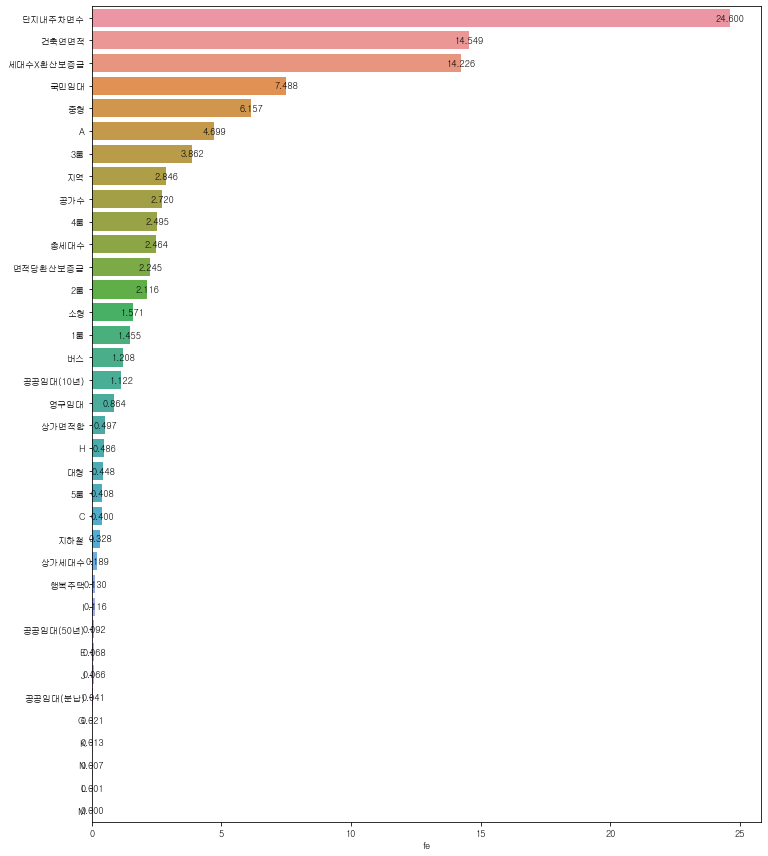

In [1209]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(np.array(fe).mean(axis=0),
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### LGBM

In [1071]:
FOLD = 10
preds = []
fe = []

cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in cross.split(x_train, y_train):
    folds.append((train_idx, valid_idx))

models={}
for fold in range(FOLD):
    train_idx, valid_idx = folds[fold]
    X_tra = x_train.iloc[train_idx, :]
    y_tra = y_train.iloc[train_idx]
    X_val = x_train.iloc[valid_idx, :]
    y_val = y_train.iloc[valid_idx]

    model=LGBMRegressor(learning_rate=0.0027, random_state=42, n_estimators=10000, cat_features = cat_features,)
    model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
              eval_metric='mae',
              early_stopping_rounds=30, verbose=100)
    models[fold]=model

for k in range(FOLD):
    preds.append(models[k].predict(x_test)) 
    fe.append(models[k].feature_importances_)

[LightGBM] [Warning] Unknown parameter: cat_features
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 240.314	training's l2: 104956	valid_1's l1: 207.044	valid_1's l2: 62350.8
[200]	training's l1: 197.523	training's l2: 73560.1	valid_1's l1: 178.928	valid_1's l2: 46562.7
[300]	training's l1: 165.606	training's l2: 54000.4	valid_1's l1: 156.641	valid_1's l2: 36776.4
[400]	training's l1: 142.523	training's l2: 41828.4	valid_1's l1: 139.792	valid_1's l2: 30919.7
[500]	training's l1: 125.188	training's l2: 33836.2	valid_1's l1: 130.097	valid_1's l2: 27866.1
[600]	training's l1: 111.971	training's l2: 28726.6	valid_1's l1: 121.576	valid_1's l2: 24712.1
[700]	training's l1: 102.504	training's l2: 25300.7	valid_1's l1: 115.748	valid_1's l2: 22989.4
[800]	training's l1: 95.4662	training's l2: 22748.4	valid_1's l1: 110.781	valid_1's l2: 21727.1
[900]	training's l1: 90.2518	training's l2: 20827.1	valid_1's l1: 107.884	valid_1's l2: 20811.6
[1000]	training's l1: 8

In [1072]:
pred = np.array(preds).mean(axis=0)

In [1073]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [1074]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [1075]:
sub.head()

,code,num
0,C1072,828.538242
1,C1128,1398.144230
2,C1456,511.390430
3,C1840,511.140215
4,C1332,1382.880815


In [466]:
sub.to_csv('submission/parking_210713_allnew+ag-withllar.csv', index=False)

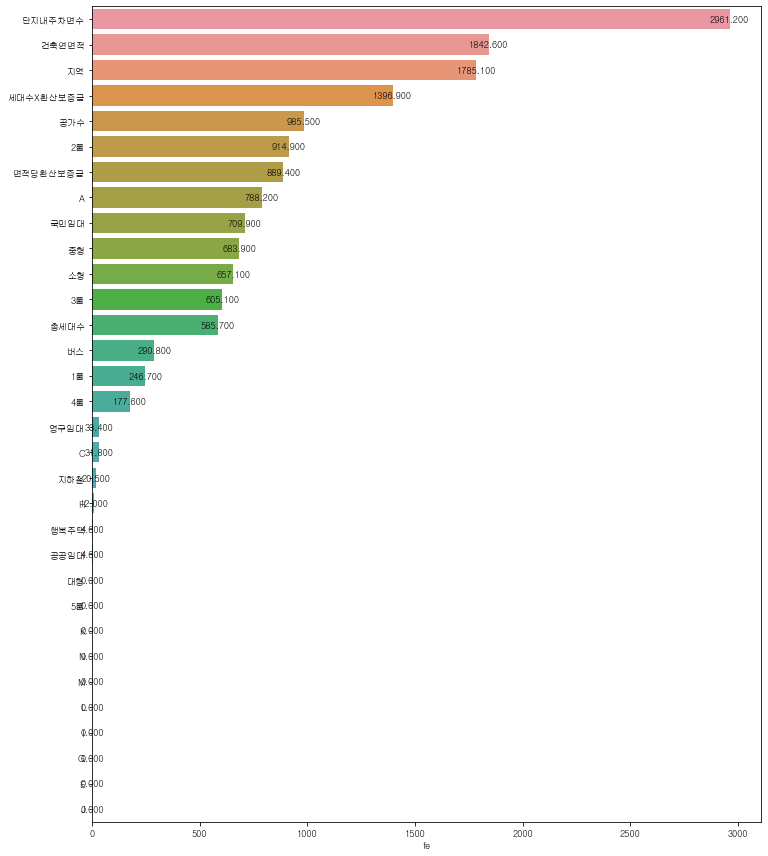

In [1076]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(np.array(fe).mean(axis=0),
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## pycaret

In [1217]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          #'numeric_features' : None,
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : True,
          'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          'ignore_low_variance' : True,
          'combine_rare_levels' : False,
          'rare_level_threshold' : 0.10,
          'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          'remove_multicollinearity' : True,
          'multicollinearity_threshold' : 0.9,
          'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          'feature_selection' : True,
          'feature_selection_threshold' : 0.8,
          'feature_interaction' : False,
          'feature_ratio' : False,
          'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          'data_split_shuffle' : True,
          'n_jobs' : -1,
          'html' : True,
          'session_id' : 42,
          'log_experiment' : False,
          'experiment_name' : None,
          'log_plots' : False,
          'log_profile' : False,
          'log_data' : False,
          'silent': False,
          'verbose' : True,
          'profile' : False}

In [1218]:
exp_clf101 = setup(**params,
                   data = train, target = '등록차량수')

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(420, 38)"
3,Missing Values,False
4,Numeric Features,34
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(336, 33)"


In [1219]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,107.6778,28207.9448,162.7924,0.8086,0.3672,0.3297,0.0050
lasso,Lasso Regression,111.5751,29339.3676,166.5246,0.8036,0.3620,0.3244,0.4080
par,Passive Aggressive Regressor,112.1207,29599.0352,167.5930,0.7971,0.3666,0.3240,0.0040
br,Bayesian Ridge,113.1989,30670.4698,169.5525,0.7920,0.4161,0.3434,0.0030
llar,Lasso Least Angle Regression,114.1826,30892.9227,171.3515,0.7924,0.3634,0.3389,0.0030
lr,Linear Regression,115.6082,31157.2979,171.7441,0.7860,0.4434,0.3554,0.6390
omp,Orthogonal Matching Pursuit,124.5495,33990.8470,178.9894,0.7664,0.3800,0.3434,0.0030
rf,Random Forest Regressor,122.7480,37292.6633,187.3495,0.7519,0.3279,0.2886,0.0290
et,Extra Trees Regressor,122.0740,37463.2943,188.3957,0.7453,0.3215,0.2803,0.0260
gbr,Gradient Boosting Regressor,122.3727,38712.1979,189.8958,0.7395,0.3576,0.3114,0.0110


In [1220]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          #'numeric_features' : None,
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : False,
          #'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          #'ignore_low_variance' : True,
          #'combine_rare_levels' : False,
          #'rare_level_threshold' : 0.10,
          #'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          #'remove_multicollinearity' : True,
          #'multicollinearity_threshold' : 0.9,
          #'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          #'feature_selection' : True,
          #'feature_selection_threshold' : 0.8,
          #'feature_interaction' : False,
          #'feature_ratio' : False,
          #'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          #'data_split_shuffle' : True,
          'n_jobs' : -1,
          #'html' : True,
          'session_id' : 42,
          #'log_experiment' : False,
          #'experiment_name' : None,
          #'log_plots' : False,
          #'log_profile' : False,
          #'log_data' : False,
          #'silent': False,
          #'verbose' : True,
          #'profile' : False
         }

In [1221]:
exp_clf101 = setup(**params,
                   data = train, target = '등록차량수')

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(420, 38)"
3,Missing Values,False
4,Numeric Features,34
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(336, 50)"


In [1222]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,115.4606,32007.9598,174.4338,0.7854,0.3601,0.3342,0.0040
br,Bayesian Ridge,115.1530,32348.4077,175.8547,0.7791,0.3369,0.3002,0.0030
en,Elastic Net,118.4416,33364.7336,177.2663,0.7783,0.3543,0.3237,0.0040
lasso,Lasso Regression,120.4563,34293.5724,179.2061,0.7717,0.4049,0.3551,0.0040
rf,Random Forest Regressor,121.9145,36704.7211,185.7129,0.7567,0.3253,0.2861,0.0290
et,Extra Trees Regressor,122.2904,37425.8751,188.0087,0.7462,0.3201,0.2780,0.0280
omp,Orthogonal Matching Pursuit,125.6791,37865.3367,186.9592,0.7405,0.4226,0.3270,0.0040
catboost,CatBoost Regressor,118.1137,38244.6083,188.2075,0.7507,0.3345,0.2876,0.4100
gbr,Gradient Boosting Regressor,122.3430,38708.6424,190.7406,0.7383,0.3565,0.3139,0.0120
xgboost,Extreme Gradient Boosting,123.8990,39000.7564,189.9324,0.7440,0.3375,0.2806,0.0740


In [394]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          'numeric_features' : ['G', 'M'],
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : False,
          #'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          #'ignore_low_variance' : True,
          #'combine_rare_levels' : False,
          #'rare_level_threshold' : 0.10,
          #'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          #'remove_multicollinearity' : True,
          #'multicollinearity_threshold' : 0.9,
          #'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          'feature_selection' : True,
          'feature_selection_threshold' : 0.8,
          #'feature_interaction' : False,
          #'feature_ratio' : False,
          #'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          #'data_split_shuffle' : True,
          'n_jobs' : -1,
          #'html' : True,
          'session_id' : 42,
          #'log_experiment' : False,
          #'experiment_name' : None,
          #'log_plots' : False,
          #'log_profile' : False,
          #'log_data' : False,
          #'silent': False,
          #'verbose' : True,
          #'profile' : False
         }

In [395]:
exp_clf101 = setup(**params, data = train, target = '등록차량수')

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(413, 64)"
3,Missing Values,False
4,Numeric Features,61
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(330, 75)"


In [396]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,118.1959,33345.4542,177.2042,0.7761,0.3911,0.3700,0.0030
br,Bayesian Ridge,119.6651,34092.0750,178.5938,0.7682,0.3692,0.3339,0.0030
et,Extra Trees Regressor,119.9006,34563.0557,179.7676,0.7639,0.3620,0.3295,0.0320
rf,Random Forest Regressor,120.5796,34831.4321,182.6575,0.7569,0.3804,0.3453,0.0350
catboost,CatBoost Regressor,117.2781,35028.5869,179.0562,0.7662,0.3940,0.3653,0.4720
gbr,Gradient Boosting Regressor,124.5455,37779.5620,190.2079,0.7392,0.4029,0.3681,0.0160
xgboost,Extreme Gradient Boosting,126.7993,37873.2865,190.1678,0.7405,0.3858,0.3271,0.0790
omp,Orthogonal Matching Pursuit,128.2238,38188.7830,190.4287,0.7382,0.4316,0.3709,0.0030
ada,AdaBoost Regressor,142.9593,39096.8100,195.7806,0.7228,0.5071,0.6030,0.0120
lightgbm,Light Gradient Boosting Machine,133.1246,42078.3339,201.0512,0.7070,0.4259,0.3958,0.0220
